In [11]:
import bilby
import numpy as np

import bilby.core.likelihood.simulation_based_inference as sbibilby
from bilby.core.likelihood.simulation_based_inference import GenerateData
import matplotlib.pyplot as plt

In [12]:
class GenerateWhitenedIFONoise(GenerateData):
    """
    TBD
    Parameters
    ==========
    num_data:
    """

    def __init__(self, ifo):
        super(GenerateWhitenedIFONoise, self).__init__(
            parameters=dict(sigma=None),
            call_parameter_key_list=["sigma"],
        )
        self.ifo = ifo

    def get_data(self, parameters: dict):
        self.parameters.update(parameters)
        sigma = self.parameters["sigma"]
        self.ifo.set_strain_data_from_power_spectral_density(
            sampling_frequency=self.ifo.sampling_frequency,
            duration=self.ifo.duration,
            start_time=self.ifo.start_time,
        )
        whitened_strain = self.ifo.whitened_time_domain_strain * np.array(sigma)
        return whitened_strain


class GenerateWhitenedSignal(GenerateData):
    """
    TBD

    Parameters
    ==========
    ifo:

    waveform_generator:

    bilby_prior:
    """

    def __init__(self, ifo, waveform_generator, signal_prior):
        call_parameter_key_list = signal_prior.non_fixed_keys
        parameters = signal_prior.sample()

        super(GenerateWhitenedSignal, self).__init__(
            parameters=parameters,
            call_parameter_key_list=call_parameter_key_list,
        )
        self.ifo = ifo
        self.waveform_generator = waveform_generator

    def get_data(self, parameters: dict):
        self.parameters.update(parameters)
        parameters = self.parameters

        # Simulate the GW signal
        waveform_polarizations = waveform_generator.time_domain_strain(parameters)
        signal = {}
        for mode in waveform_polarizations.keys():
            det_response = self.ifo.antenna_response(
                parameters['ra'],
                parameters['dec'],
                parameters['geocent_time'],
                parameters['psi'], mode)
            signal[mode] = waveform_polarizations[mode] * det_response
        ht = sum(signal.values())

        # Correct the time
        time_shift = self.ifo.time_delay_from_geocenter(
            parameters['ra'], parameters['dec'], parameters['geocent_time'])
        dt_geocent = parameters['geocent_time'] - self.ifo.strain_data.start_time
        dt = dt_geocent + time_shift
        nroll = int(dt * self.ifo.sampling_frequency)
        ht = np.roll(ht, nroll)

        # Whiten the time-domain signal
        frequency_window_factor = (
            np.sum(self.ifo.frequency_mask)
            / len(self.ifo.frequency_mask)
        )
        
        hf = np.fft.rfft(ht) / self.ifo.sampling_frequency
        ht_tilde = (
            np.fft.irfft(hf / (self.ifo.amplitude_spectral_density_array * np.sqrt(self.ifo.duration / 4)))
            * np.sqrt(np.sum(self.ifo.frequency_mask)) / frequency_window_factor
        )

        return ht_tilde

In [23]:
injection_parameters = dict(
    mass_1=30.0,
    mass_2=30.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=1000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

#injection_parameters['sigma'] = 1

signal_priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
    "luminosity_distance",
    "theta_jn"
]:
    signal_priors[key] = injection_parameters[key]
signal_priors['mass_ratio']=29.0/36.0
#signal_priors['chirp_mass']=bilby.gw.prior.UniformInComponentsChirpMass(minimum=20, maximum=40, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
noise_priors = bilby.core.prior.PriorDict(dict(sigma=bilby.core.prior.Uniform(0, 2, 'sigma')))

duration = 4.0
sampling_frequency = 1024.0
minimum_frequency = 20
trigger = 1126259642.4
start_time = trigger - duration / 2

waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)



ifos = bilby.gw.detector.InterferometerList(['H1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=start_time,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)
ifo = ifos[0]

11:44 bilby INFO    : No prior given, using default BBH priors in /home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
11:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
11:44 bilby INFO    : Injected signal in H1:
11:44 bilby INFO    :   optimal SNR = 22.17
11:44 bilby INFO    :   matched filter SNR = 23.55+0.04j
11:44 bilby INFO    :   mass_1 = 30.0
11:44 bilby INFO    :   mass_2 = 30.0
11:44 bilby INFO    :   a_1 = 0.4
11:44 bilby INFO    :   a_2 = 0.3
11:44 bilby INFO    :   tilt_1 = 0.5
11:44 bilby INFO    :   tilt_2 = 1.0
11:44 bilby INFO    :   phi_12 = 1.7
11:44 bilby INFO    :   phi_jl = 0.3
11:44 bilby INFO    :   luminosity_distance = 1000.0
11:44 bilby INFO    :   theta_jn = 0.4
11:44 bilby INFO    :   psi = 2.659
11:44 bi

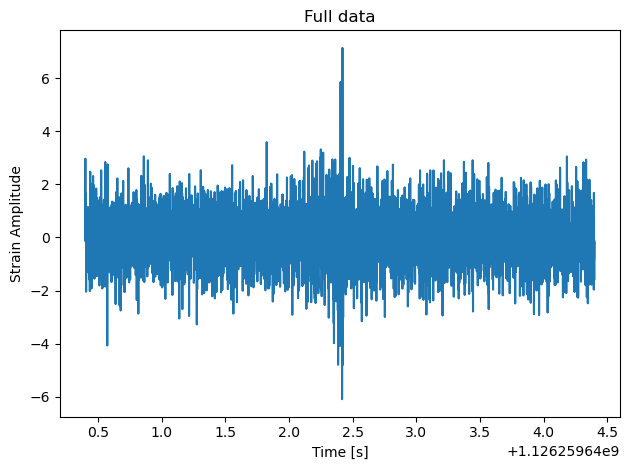

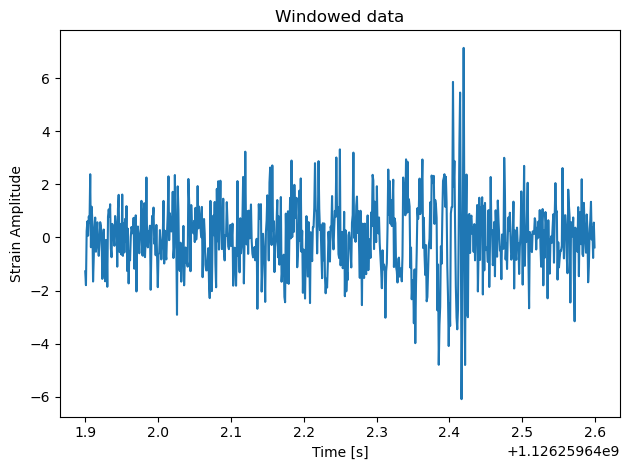

In [24]:
fig, ax = plt.subplots()

yobs = ifo.whitened_time_domain_strain
xobs = ifo.time_array

trigger_time = 1126259642.4
window_start = trigger_time - 0.5
window_end = trigger_time + 0.2

# Create mask to select data within the desired window
mask = (xobs >= window_start) & (xobs <= window_end)
cut_time = xobs[mask]
cut_data = yobs[mask]

plt.plot(xobs, yobs)
plt.xlabel('Time [s]')
plt.ylabel('Strain Amplitude')
plt.title('Full data')
#ax.set(xlim=(trigger - 0.2, trigger + 0.1))
#ax.set(xlim=(trigger - 0.5, trigger + 0.5))
plt.tight_layout()
plt.savefig('Results/Data/full_strain_example.png', dpi=100)
plt.show()

plt.plot(cut_time, cut_data)
plt.xlabel('Time [s]')
plt.ylabel('Strain Amplitude')
plt.title('Windowed data')
plt.tight_layout()
plt.savefig('Results/Data/windowed_strain_example.png', dpi=100)
plt.show()

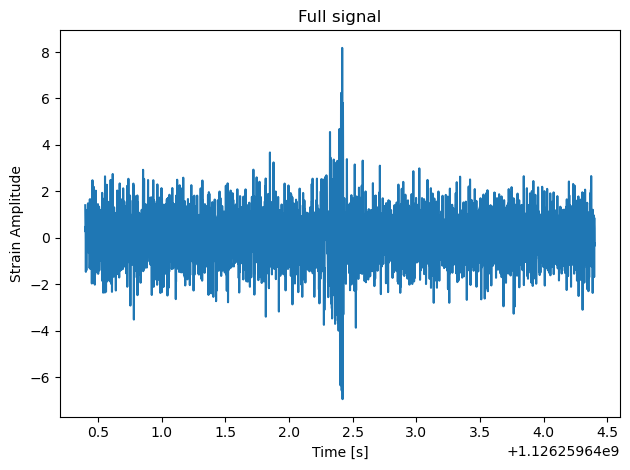

In [25]:

#With windowed data
# noise = GenerateWhitenedIFONoise(ifo,True)
# signal = GenerateWhitenedSignal(ifo, waveform_generator, signal_priors, True)
# signal_and_noise = sbibilby.AdditiveSignalAndNoise(signal, noise)

# priors = noise_priors | signal_priors
# priors = bilby.core.prior.PriorDict(priors)
# priors.convert_floats_to_delta_functions()
# sample = priors.sample()
# plt.plot(cut_time,signal_and_noise.get_data(sample))
# plt.xlabel('Time [s]')
# plt.ylabel('Strain Amplitude')
# plt.title('Windowed signal')
# plt.tight_layout()
# plt.savefig('Results/Data/windowed_signal_example.png', dpi=100)
# plt.show()


#With full data
full_noise = GenerateWhitenedIFONoise(ifo)#,False)
full_signal = GenerateWhitenedSignal(ifo, waveform_generator, signal_priors)#, False)
full_signal_and_noise = sbibilby.AdditiveSignalAndNoise(full_signal, full_noise)

priors = noise_priors | signal_priors
priors = bilby.core.prior.PriorDict(priors)
priors.convert_floats_to_delta_functions()
sample = priors.sample()

injection_parameters['sigma']=1
plt.plot(xobs,full_signal_and_noise.get_data(injection_parameters))
plt.xlabel('Time [s]')
plt.ylabel('Strain Amplitude')
plt.title('Full signal')
plt.tight_layout()
plt.savefig('Results/Data/full_signal_example.png', dpi=100)
plt.show()

In [18]:
import time
num_simulations=100
label = "TEST_chirp_windowed_res"+str(num_simulations)
use_mask=True
#Windowed signal
likelihood = sbibilby.NLEResidualLikelihood(cut_data, signal_and_noise, priors, label, num_simulations=num_simulations, cache=False)
start=time.time()
likelihood.init()
end=time.time()
total_time=end-start
print('Total time', end-start)
with open("Results/Training_time.txt", "a") as f:
     f.write(f"{total_time:.2f} {num_simulations} {use_mask}\n")
     f.close()
    
#Full signal
label="TEST_full_res"+str(num_simulations)
use_mask=False
likelihood_full = sbibilby.NLEResidualLikelihood(yobs, full_signal_and_noise, priors, label, num_simulations=num_simulations, cache=False)
start_full=time.time()
likelihood_full.init()
end_full=time.time()
print('Total time', end_full-start_full)
total_time_full=end_full-start_full
with open("Results/Training_time.txt", "a") as f:
     f.write(f"{total_time_full:.2f} {num_simulations} {use_mask}\n")
     f.close()

11:43 bilby INFO    : Initialise the SBI prior
11:43 bilby INFO    : Initialise the SBI simulator
11:43 bilby INFO    : Initialise training


KeyboardInterrupt: 

In [9]:
live_points=500
outdir = "Results/outdir_chirp_mass_testing_notebook_3"

In [10]:

label = "TEST_windowed_nlive"+str(live_points)+'_nsim'+str(num_simulations)
start=time.time()
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    npoints=live_points,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    check_point_delta_t=120,
    #conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
)
end=time.time()
print(end-start)

start=time.time()
label = "TEST_full_nlive"+str(live_points)+'_nsim'+str(num_simulations)
result_full = bilby.run_sampler(
    likelihood=likelihood_full,
    priors=priors,
    sampler="dynesty",
    npoints=live_points,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    check_point_delta_t=120,
    #conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
)
end=time.time()
print(end-start)

14:54 bilby INFO    : Running for label 'TEST_windowed_nlive500_nsim100', output will be saved to 'Results/outdir_chirp_mass_testing_notebook_3'
14:55 bilby INFO    : Analysis priors:
14:55 bilby INFO    : sigma=Uniform(minimum=0, maximum=2, name='sigma', latex_label='sigma', unit=None, boundary=None)
14:55 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
14:55 bilby INFO    : mass_1=Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None)
14:55 bilby INFO    : mass_2=Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None)
14:55 bilby INFO    : mass_ratio=0.8055555555555556
14:55 bilby INFO    : luminosity_distance=1000.0
14:55 bilby INFO    : dec=-1.2108
14:55 bilby INFO    : ra=1.375
14:55 bilby INFO    : theta_jn=0.4
14:55 bilby INFO    : psi=2.659
14:55 bilby INFO    : phase=1.3
14:55 bilby INFO    : a_1=0.4
14:

1it [00:00, ?it/s]

14:57 bilby INFO    : Written checkpoint file Results/outdir_chirp_mass_testing_notebook_3/TEST_windowed_nlive500_nsim100_resume.pickle
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
14:59 bilby INFO    : Written checkpoint file Results/outdir_chirp_mass_testing_notebook_3/TEST_windowed_nlive500_nsim100_resume.pickle
14:59 bilby

16:08 bilby INFO    : Rejection sampling nested samples to obtain 1550 posterior samples
16:08 bilby INFO    : Sampling time: 1:13:09.000026
16:08 bilby INFO    : Summary of results:
nsamples: 1550
ln_noise_evidence:    nan
ln_evidence: -6299.424 +/-  0.225
ln_bayes_factor:    nan +/-  0.225

16:08 bilby INFO    : Running for label 'TEST_full_nlive500_nsim100', output will be saved to 'Results/outdir_chirp_mass_testing_notebook_3'


4413.11065864563


16:08 bilby INFO    : Analysis priors:
16:08 bilby INFO    : sigma=Uniform(minimum=0, maximum=2, name='sigma', latex_label='sigma', unit=None, boundary=None)
16:08 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
16:08 bilby INFO    : mass_1=Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None)
16:08 bilby INFO    : mass_2=Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None)
16:08 bilby INFO    : mass_ratio=0.8055555555555556
16:08 bilby INFO    : luminosity_distance=1000.0
16:08 bilby INFO    : dec=-1.2108
16:08 bilby INFO    : ra=1.375
16:08 bilby INFO    : theta_jn=0.4
16:08 bilby INFO    : psi=2.659
16:08 bilby INFO    : phase=1.3
16:08 bilby INFO    : a_1=0.4
16:08 bilby INFO    : a_2=0.3
16:08 bilby INFO    : tilt_1=0.5
16:08 bilby INFO    : tilt_2=1.0
16:08 bilby INFO    : phi_12=1.7
16:08 bilby INFO   

1it [00:00, ?it/s]

16:11 bilby INFO    : Written checkpoint file Results/outdir_chirp_mass_testing_notebook_3/TEST_full_nlive500_nsim100_resume.pickle
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:786: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0., max(y0) * 1.05])
/home/mattia.emma/.conda/envs/sbi/lib/python3.10/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])
16:13 bilby INFO    : Written checkpoint file Results/outdir_chirp_mass_testing_notebook_3/TEST_full_nlive500_nsim100_resume.pickle
/home/mattia.emma/.

18:04 bilby INFO    : Rejection sampling nested samples to obtain 1624 posterior samples
18:04 bilby INFO    : Sampling time: 1:55:30.729628
18:04 bilby INFO    : Summary of results:
nsamples: 1624
ln_noise_evidence:    nan
ln_evidence: -22436.104 +/-  0.232
ln_bayes_factor:    nan +/-  0.232



6960.814633607864


In [ ]:
result=bilby.core.result.read_in_result(filename='Results/Test/TEST_windowed_nlive'+str(live_points)+'_nsim'+str(num_simulations)+'_result.json')
print(result.parameter_labels)

result_full=bilby.core.result.read_in_result(filename='Results/Test/TEST_full_nlive'+str(live_points)+'_nsim'+str(num_simulations)+'_result.json')
print(result_full.parameter_labels)

In [ ]:
truths = {'sigma':1.0,'chirp_mass':30}
result.plot_corner(truths=truths)
result_full.plot_corner(truths=truths)

In [ ]:
live_points=500
reference_priors = signal_priors
reference_priors = bilby.core.prior.PriorDict(reference_priors)
reference_priors.convert_floats_to_delta_functions()


reference_likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifos,
    waveform_generator,
    priors=reference_priors,
 )
label = "TEST_reference_nlive"+str(live_points)
kwargs = dict(npoints=live_points, sampler="dynesty", check_point_delta_t=120)
result_reference = bilby.run_sampler(
            likelihood=reference_likelihood,
            priors=reference_priors,
            outdir=outdir,
            injection_parameters=injection_parameters,
            label=label,
            conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
            **kwargs,
        )

In [ ]:
result_reference_json=bilby.core.result.read_in_result(filename='Results/outdir_1/TEST_reference_nlive'+str(live_points)+'_result.json')
print(result_reference_json.parameter_labels)

In [11]:
result=bilby.core.result.read_in_result(filename='Results/outdir_chirp_mass_25_11_injection/TEST_full_single_nlive500_nsim1000_result.json')

In [25]:
result_reference=bilby.core.result.read_in_result(filename='Results/outdir_chirp_mass_25_11/TEST_reference_withsbi_nlive500_nsim1000_result.json')